## Fine tune GPT2 using pytorch

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import random
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config
from tqdm.notebook import tqdm as notebook_tqdm

from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler

In [145]:
data = pd.read_csv("data/eng_fr_trans.csv", usecols=["eng"]).sample(n=50, random_state=42)
data = data.reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   eng     50 non-null     object
dtypes: object(1)
memory usage: 532.0+ bytes


In [146]:
data.head(5)

,eng
0,I can't concentrate if you keep tapping me on ...
1,Where are your things?
2,Tom has too many strange ideas.
3,How is your new class?
4,Such a thing has never happened before.


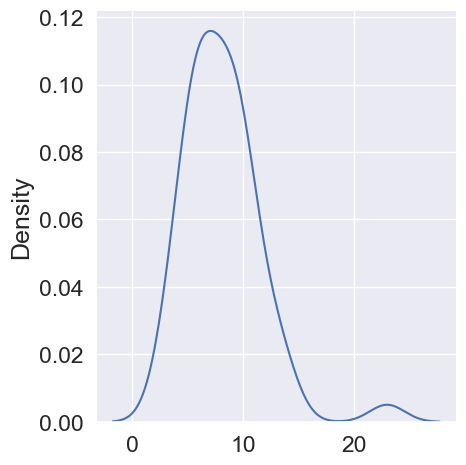

In [147]:
import nltk

doc_lengths = []

for bio in data["eng"]:

    # get rough token count distribution
    tokens = nltk.word_tokenize(bio)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.displot(doc_lengths, kind = "kde")

In [148]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
device

'cpu'

In [149]:
from torch.utils.data import Dataset
from torch.utils.data import Dataset, DataLoader, random_split
# import os
# import json
# import csv

class CustomDataset(Dataset):
    def __init__(self, dataset, tokenizer, max_length=768):

        self.tokenizer = tokenizer
        self.dataset = dataset
        self.input_ids = []
        self.attn_masks = []

        for idx, row in self.dataset.iterrows():
            encodings_dict = tokenizer('<|startoftext|>'+ row["eng"] + '<|endoftext|>', 
                                       truncation=True, 
                                       max_length=max_length, 
                                       padding="max_length")

            self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
            self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            "input_ids":self.input_ids[idx], 
            "attention_mask": self.attn_masks[idx] 
            }

In [150]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', 
                                          bos_token='<|startoftext|>', 
                                          eos_token='<|endoftext|>', 
                                          pad_token='<|pad|>')

In [151]:
dataset = CustomDataset(data, tokenizer, max_length=768)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

   45 training samples
    5 validation samples


In [172]:
batch_size=5
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

len(train_dataloader.dataset)

45

In [173]:
# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

len(validation_dataloader.dataset)

5

In [174]:
# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

In [175]:
# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cpu")
# model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [176]:
# some parameters I cooked up that work reasonably well

epochs = 5
learning_rate = 5e-4
warmup_steps = 2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 5

In [177]:
from transformers import get_linear_schedule_with_warmup

# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = torch.optim.AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon,
                  weight_decay=0.01, #a form of regularization that penalizes complexity. Stops model from getting too complex or high degree. 
                  # We are subtracting a constant times the weight from the original weight
                )

In [178]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, # increases from 0 to lr
                                            num_training_steps = total_steps,
                                            gamma=0.1 # Multiplicative factor of learning rate decay. Default: 0.1.
                                            )

In [179]:
from tqdm import tqdm
training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):
    total_train_loss = 0
    model.train()

    for step, batch in tqdm(enumerate(train_dataloader)):

        b_input_ids = batch["input_ids"].to(device)
        b_labels = batch["input_ids"].to(device)
        b_masks = batch["attention_mask"].to(device)

        model.zero_grad()        
        # Outputs - loss, logits, past_key_values
        # Output is of size torch.Size([1, 768, 50259])
        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )  

        # print("Model output - \n", outputs["logits"].shape)
        loss = outputs[0] 
        batch_loss = loss.item()
        total_train_loss += batch_loss

        # if step % sample_every == 0 and not step == 0:
        #     print("STEP == ", step)

        loss.backward()
        optimizer.step() # To update the weights
        # Params - dict_keys(['params', 'lr', 'betas', 'eps', 'weight_decay', 'amsgrad', 'foreach', 'maximize', 'capturable', 'differentiable', 'fused', 'initial_lr'])
        
        # print(optimizer.param_groups[1].keys()) 
        print(f"loss = {batch_loss}, Learning rate optimizer = {optimizer.param_groups[0]['lr']}")
    scheduler.step()
    print('Epoch:', epoch_i,'Scheduler LR:', scheduler.get_last_lr())

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    
    print("Running Validation...")
    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch["input_ids"].to(device)
        b_labels = batch["input_ids"].to(device)
        b_masks = batch["attention_mask"].to(device)
        
        with torch.no_grad():        
            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
        }
    )

print("Training complete!")

1it [00:18, 18.78s/it]

loss = 2.9225988388061523, Learning rate optimizer = 0.0
Epoch: 0 Scheduler LR: [0.00025]


2it [00:42, 21.67s/it]

loss = 2.4566898345947266, Learning rate optimizer = 0.00025
Epoch: 0 Scheduler LR: [0.0005]


3it [01:05, 22.52s/it]

loss = 1.7161850929260254, Learning rate optimizer = 0.0005
Epoch: 0 Scheduler LR: [0.0004883720930232558]


4it [01:28, 22.52s/it]

loss = 1.1837915182113647, Learning rate optimizer = 0.0004883720930232558
Epoch: 0 Scheduler LR: [0.00047674418604651167]


5it [01:50, 22.32s/it]

loss = 0.9694986343383789, Learning rate optimizer = 0.00047674418604651167
Epoch: 0 Scheduler LR: [0.00046511627906976747]


6it [02:10, 21.49s/it]

loss = 0.7533876299858093, Learning rate optimizer = 0.00046511627906976747
Epoch: 0 Scheduler LR: [0.0004534883720930232]


7it [02:33, 22.11s/it]

loss = 0.625762403011322, Learning rate optimizer = 0.0004534883720930232
Epoch: 0 Scheduler LR: [0.00044186046511627907]


8it [02:57, 22.65s/it]

loss = 0.8119134306907654, Learning rate optimizer = 0.00044186046511627907
Epoch: 0 Scheduler LR: [0.00043023255813953487]


9it [03:19, 22.19s/it]


loss = 0.6751548051834106, Learning rate optimizer = 0.00043023255813953487
Epoch: 0 Scheduler LR: [0.0004186046511627907]
  Average training loss: 1.35


1it [00:22, 22.51s/it]

loss = 0.419208824634552, Learning rate optimizer = 0.0004186046511627907
Epoch: 1 Scheduler LR: [0.00040697674418604653]


2it [00:42, 20.86s/it]

loss = 0.6553399562835693, Learning rate optimizer = 0.00040697674418604653
Epoch: 1 Scheduler LR: [0.00039534883720930233]


3it [01:02, 20.60s/it]

loss = 0.37801530957221985, Learning rate optimizer = 0.00039534883720930233
Epoch: 1 Scheduler LR: [0.0003837209302325582]


4it [01:20, 19.49s/it]

loss = 0.4633985161781311, Learning rate optimizer = 0.0003837209302325582
Epoch: 1 Scheduler LR: [0.00037209302325581393]


5it [01:38, 19.09s/it]

loss = 0.4646109342575073, Learning rate optimizer = 0.00037209302325581393
Epoch: 1 Scheduler LR: [0.00036046511627906973]


6it [01:58, 19.46s/it]

loss = 0.6431541442871094, Learning rate optimizer = 0.00036046511627906973
Epoch: 1 Scheduler LR: [0.0003488372093023256]


7it [02:16, 18.87s/it]

loss = 0.4705309271812439, Learning rate optimizer = 0.0003488372093023256
Epoch: 1 Scheduler LR: [0.0003372093023255814]


8it [02:35, 18.92s/it]

loss = 0.4550429582595825, Learning rate optimizer = 0.0003372093023255814
Epoch: 1 Scheduler LR: [0.00032558139534883724]


9it [02:53, 19.29s/it]


loss = 0.5282221436500549, Learning rate optimizer = 0.00032558139534883724
Epoch: 1 Scheduler LR: [0.00031395348837209304]
  Average training loss: 0.50


1it [00:17, 17.47s/it]

loss = 0.5136868953704834, Learning rate optimizer = 0.00031395348837209304
Epoch: 2 Scheduler LR: [0.00030232558139534885]


2it [00:37, 19.27s/it]

loss = 0.3527964949607849, Learning rate optimizer = 0.00030232558139534885
Epoch: 2 Scheduler LR: [0.00029069767441860465]


3it [00:55, 18.30s/it]

loss = 0.48770350217819214, Learning rate optimizer = 0.00029069767441860465
Epoch: 2 Scheduler LR: [0.00027906976744186045]


4it [01:14, 18.57s/it]

loss = 0.5080380439758301, Learning rate optimizer = 0.00027906976744186045
Epoch: 2 Scheduler LR: [0.00026744186046511625]


5it [01:33, 18.86s/it]

loss = 0.4591310918331146, Learning rate optimizer = 0.00026744186046511625
Epoch: 2 Scheduler LR: [0.0002558139534883721]


6it [01:52, 18.87s/it]

loss = 0.5232735276222229, Learning rate optimizer = 0.0002558139534883721
Epoch: 2 Scheduler LR: [0.0002441860465116279]


7it [02:09, 18.41s/it]

loss = 0.385944128036499, Learning rate optimizer = 0.0002441860465116279
Epoch: 2 Scheduler LR: [0.00023255813953488373]


8it [02:28, 18.52s/it]

loss = 0.37636324763298035, Learning rate optimizer = 0.00023255813953488373
Epoch: 2 Scheduler LR: [0.00022093023255813954]


9it [02:47, 18.62s/it]


loss = 0.3569185733795166, Learning rate optimizer = 0.00022093023255813954
Epoch: 2 Scheduler LR: [0.00020930232558139536]
  Average training loss: 0.44


1it [00:19, 19.08s/it]

loss = 0.40238916873931885, Learning rate optimizer = 0.00020930232558139536
Epoch: 3 Scheduler LR: [0.00019767441860465116]


2it [00:37, 18.55s/it]

loss = 0.2538599371910095, Learning rate optimizer = 0.00019767441860465116
Epoch: 3 Scheduler LR: [0.00018604651162790697]


3it [00:55, 18.62s/it]

loss = 0.3578801155090332, Learning rate optimizer = 0.00018604651162790697
Epoch: 3 Scheduler LR: [0.0001744186046511628]


4it [01:14, 18.66s/it]

loss = 0.42769449949264526, Learning rate optimizer = 0.0001744186046511628
Epoch: 3 Scheduler LR: [0.00016279069767441862]


5it [01:31, 18.03s/it]

loss = 0.27387312054634094, Learning rate optimizer = 0.00016279069767441862
Epoch: 3 Scheduler LR: [0.00015116279069767442]


6it [01:50, 18.27s/it]

loss = 0.22034379839897156, Learning rate optimizer = 0.00015116279069767442
Epoch: 3 Scheduler LR: [0.00013953488372093022]


7it [02:09, 18.49s/it]

loss = 0.27007758617401123, Learning rate optimizer = 0.00013953488372093022
Epoch: 3 Scheduler LR: [0.00012790697674418605]


8it [02:27, 18.54s/it]

loss = 0.25831085443496704, Learning rate optimizer = 0.00012790697674418605
Epoch: 3 Scheduler LR: [0.00011627906976744187]


9it [02:49, 18.80s/it]


loss = 0.2811039686203003, Learning rate optimizer = 0.00011627906976744187
Epoch: 3 Scheduler LR: [0.00010465116279069768]
  Average training loss: 0.31


1it [00:18, 18.60s/it]

loss = 0.1628037393093109, Learning rate optimizer = 0.00010465116279069768
Epoch: 4 Scheduler LR: [9.302325581395348e-05]


2it [00:38, 19.44s/it]

loss = 0.25341612100601196, Learning rate optimizer = 9.302325581395348e-05
Epoch: 4 Scheduler LR: [8.139534883720931e-05]


3it [00:56, 18.90s/it]

loss = 0.2568099796772003, Learning rate optimizer = 8.139534883720931e-05
Epoch: 4 Scheduler LR: [6.976744186046511e-05]


4it [01:17, 19.40s/it]

loss = 0.18162848055362701, Learning rate optimizer = 6.976744186046511e-05
Epoch: 4 Scheduler LR: [5.8139534883720933e-05]


5it [01:36, 19.48s/it]

loss = 0.2674546241760254, Learning rate optimizer = 5.8139534883720933e-05
Epoch: 4 Scheduler LR: [4.651162790697674e-05]


6it [01:57, 19.97s/it]

loss = 0.22224588692188263, Learning rate optimizer = 4.651162790697674e-05
Epoch: 4 Scheduler LR: [3.4883720930232556e-05]


7it [02:22, 21.59s/it]

loss = 0.17234466969966888, Learning rate optimizer = 3.4883720930232556e-05
Epoch: 4 Scheduler LR: [2.325581395348837e-05]


8it [02:42, 20.98s/it]

loss = 0.1615130752325058, Learning rate optimizer = 2.325581395348837e-05
Epoch: 4 Scheduler LR: [1.1627906976744185e-05]


9it [03:03, 20.44s/it]

loss = 0.22118163108825684, Learning rate optimizer = 1.1627906976744185e-05
Epoch: 4 Scheduler LR: [0.0]
  Average training loss: 0.21


In [139]:
# Display floats with two decimal places.
# pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss
epoch,,
1,0.066400,0.079669
2,0.053633,0.081061
3,0.046594,0.079238
4,0.042111,0.078450
5,0.039059,0.078624


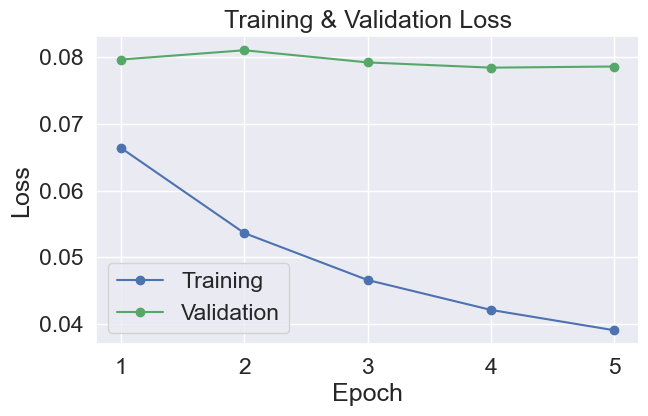

In [144]:
plt.figure(figsize=(7,4))
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4, 5])

plt.show()